<a href="https://colab.research.google.com/github/nimbuscloudservices/CST383-Project/blob/main/cst383_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Traffic Stop Victim Prediction**

Team:


1) lgallez@csumb.edu

2) smendozaloera@csumb.edu	

3) ykapadia@csumb.edu	

#Introduction


As reported by the Stanford Open Policing Project, police in the United States conduct approximately 50,000 traffic stops each day. The Stanford Open Policing project hold traffic stop data for 40 different states. Our project focuses on the data reported from the city of San Francisco in California. 


#Objective


Past findings have found that racial profiling and bias can be a reason why an individual is pulled over. Our project will predict the race of individual that is pulled over based on the reason for the traffic stop and the outcome (citation).

#Methods


San Francisco Data Set (zip file): https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_ca_san_francisco_2020_04_01.csv.zip

Stanford Digital Repository: https://purl.stanford.edu/yg821jf8611

The San Francisco Police Traffic Stop data contains has 905070 entries from 2008-2014. The data set includes 21 features. Some of these features are: Date, Time, Location, Latitude, Longitude, District, Age, Race, Sex, Outcome, Warning Issued. For the purpose of our objective, we have decided to drop variables that were not relevant to our project. 


Target:
*   race



**Predictors**:


*   outcome
*   subject_sex






In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC


In [183]:
df = pd.read_csv('https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_ca_san_francisco_2020_04_01.csv.zip',compression='zip', low_memory=False)

#Data Exploration

Due to our target variable being catergorical we must convert it to a numerical variable. We used the method label encoding.

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905070 entries, 0 to 905069
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   raw_row_number                     905070 non-null  object 
 1   date                               905070 non-null  object 
 2   time                               905035 non-null  object 
 3   location                           905027 non-null  object 
 4   lat                                903373 non-null  float64
 5   lng                                903373 non-null  float64
 6   district                           852883 non-null  object 
 7   subject_age                        846182 non-null  float64
 8   subject_race                       905070 non-null  object 
 9   subject_sex                        905070 non-null  object 
 10  type                               905070 non-null  object 
 11  arrest_made                        9050

In our initial data exploration, we see that there are a total of 22 columns and 905070 rows. Not all features share the same Dtype. The three dtype features we see are: bool, float64, and object


In [185]:
not_nums = df.select_dtypes(exclude='number')
not_nums.columns

Index(['raw_row_number', 'date', 'time', 'location', 'district',
       'subject_race', 'subject_sex', 'type', 'arrest_made', 'citation_issued',
       'warning_issued', 'outcome', 'contraband_found', 'search_conducted',
       'search_vehicle', 'search_basis', 'reason_for_stop',
       'raw_search_vehicle_description', 'raw_result_of_contact_description'],
      dtype='object')

There are 19 non-numerical features in this dataset. 

In [186]:
df.isna().mean()

raw_row_number                       0.000000
date                                 0.000000
time                                 0.000039
location                             0.000048
lat                                  0.001875
lng                                  0.001875
district                             0.057661
subject_age                          0.065065
subject_race                         0.000000
subject_sex                          0.000000
type                                 0.000000
arrest_made                          0.000000
citation_issued                      0.000000
warning_issued                       0.000000
outcome                              0.017326
contraband_found                     0.941020
search_conducted                     0.000000
search_vehicle                       0.000000
search_basis                         0.941020
reason_for_stop                      0.002444
raw_search_vehicle_description       0.000000
raw_result_of_contact_description 

Above we see the fraction of NA values per column. Contraband_found and search_basis being the highest. 


In [187]:
print("Approximately {} rows contain NA values.".format(df.isna().sum(axis=1).sum()))
df.head()

Approximately 1835818 rows contain NA values.


,raw_row_number,date,time,location,lat,lng,district,subject_age,subject_race,subject_sex,...,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_vehicle,search_basis,reason_for_stop,raw_search_vehicle_description,raw_result_of_contact_description
0,869921,2014-08-01,00:01:00,MASONIC AV & FELL ST,37.773004,-122.445873,NaN,NaN,asian/pacific islander,female,...,False,True,warning,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Warning
1,869922,2014-08-01,00:01:00,GEARY&10TH AV,37.780898,-122.468586,NaN,NaN,black,male,...,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation
2,869923,2014-08-01,00:15:00,SUTTER N OCTAVIA ST,37.786919,-122.426718,NaN,NaN,hispanic,male,...,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation
3,869924,2014-08-01,00:18:00,3RD ST & DAVIDSON,37.746380,-122.392005,NaN,NaN,hispanic,male,...,False,True,warning,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Warning
4,869925,2014-08-01,00:19:00,DIVISADERO ST. & BUSH ST.,37.786348,-122.440003,NaN,NaN,white,male,...,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation


Based on these findings, we will need to drop both columns and rows that contain NA values. This will reduce the amount of rows which will be helpful for our predictor models. 

# Data Pre-Processing 

The San Francisco data report contains variables that will not be used in this project. For example, variables that record date, time, and location will be dropped. 

In addition, we will also remove columns and rows that have missing data. A new column, outcome_map will be created in order to leverage the traffic stop outcome as a predicting feature. 

Lastly, we will use only a random sample of 50%. 






In [188]:
df.drop(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district', 'contraband_found', 'search_basis', 'raw_search_vehicle_description', 'raw_result_of_contact_description', 'type'], axis=1, inplace=True)
df = df.dropna()
df = df.sample(frac=0.5)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414850 entries, 355630 to 623682
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   subject_age       414850 non-null  float64
 1   subject_race      414850 non-null  object 
 2   subject_sex       414850 non-null  object 
 3   arrest_made       414850 non-null  bool   
 4   citation_issued   414850 non-null  bool   
 5   warning_issued    414850 non-null  bool   
 6   outcome           414850 non-null  object 
 7   search_conducted  414850 non-null  bool   
 8   search_vehicle    414850 non-null  bool   
 9   reason_for_stop   414850 non-null  object 
dtypes: bool(5), float64(1), object(4)
memory usage: 21.0+ MB


In [190]:
df.head()

,subject_age,subject_race,subject_sex,arrest_made,citation_issued,warning_issued,outcome,search_conducted,search_vehicle,reason_for_stop
355630,39.0,white,male,False,True,False,citation,False,False,Mechanical or Non-Moving Violation (V.C.)
548669,25.0,white,female,False,True,False,citation,False,False,Moving Violation
498704,39.0,other,male,False,True,False,citation,False,False,Moving Violation
694060,25.0,black,male,False,False,True,warning,False,False,Mechanical or Non-Moving Violation (V.C.)
613852,24.0,hispanic,male,False,True,False,citation,False,False,Moving Violation


After our inital pre-processing, we see that we now have 8 columns. All with the name non-null count. Five of our features are of dtype bool and 3 are of dtype object. 


Example of Features:


*   subject_race: 'asian/pacific islander', 'black','hispanic', 'white', 'other'
*   subject_sex: 'female', 'male'
*   arrest_made: True, False
*   citation_issued: True, False
*   warning_issued: True, False
*   outcome: 'warning', 'citation', 'arrest'
*   search_conducted: True, False
*   search_vehicle: True, False


**Final Pre-processing**

Lastly we will use label encoder to convert our predictor feature, outcome, and our target feature, race, to numerical values. 

In [191]:
df ['outcome'] = preprocessing.LabelEncoder().fit_transform(df['outcome'])
df ['subject_race'] = preprocessing.LabelEncoder().fit_transform(df['subject_race'])

**Data Visualization**



Text(0.5, 0, '')

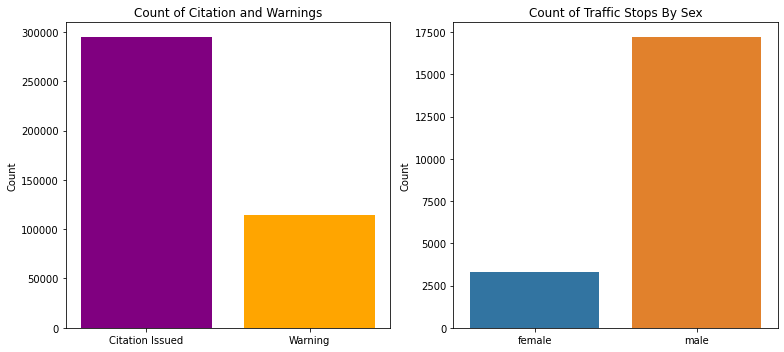

In [192]:

result = ['Citation Issued', 'Warning']
sum_of_result = [df.citation_issued.sum(), df.warning_issued.sum()]

plt.figure(tight_layout=True, figsize=(11, 5))

plt.subplot(1,2,1)
plt.bar(result, sum_of_result, color=['purple', 'orange'])
plt.title("Count of Citation and Warnings")
plt.ylabel("Count")


sex = df.groupby('subject_sex')['search_vehicle'].sum()
plt.subplot(1,2,2)
sns.barplot(x = sex.index, y = sex.values)
plt.title("Count of Traffic Stops By Sex")
plt.ylabel("Count")
plt.xlabel("")

First we will explore two differnt variables in from the datase. On the left plot, we conducted a bar plot that displays the amount of citations vs warnings that were given. We see that police officers in this dataset gave more citations than warnings. 

Next, we see that police officers performed traffic stops on male subjects more than females. 

Text(0.5, 0, 'Race')

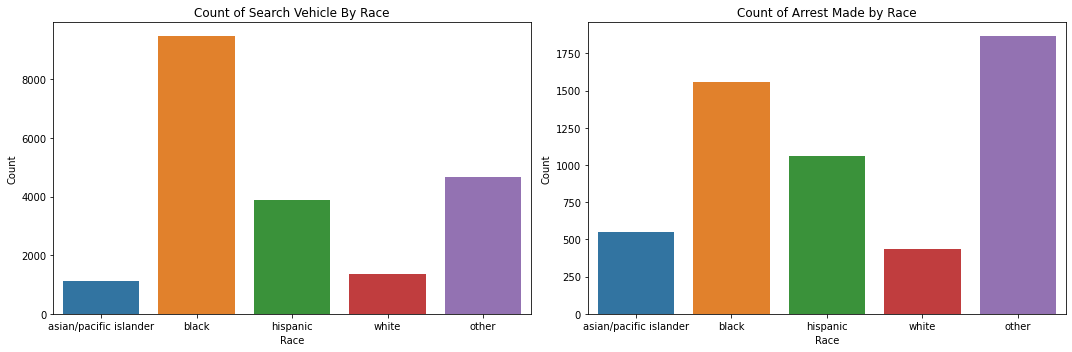

In [193]:
tick = ['asian/pacific islander', 'black', 'hispanic', 'white', 'other']
search = df.groupby('subject_race')['search_vehicle'].sum().sort_values()
plt.figure(tight_layout=True, figsize=(15, 5))
plt.subplot(1,2,1)
sns.barplot(x = search.index, y = search.values).set_xticklabels(tick)
plt.title("Count of Search Vehicle By Race")
plt.ylabel("Count")
plt.xlabel("Race")

arrest = df.groupby('subject_race')['arrest_made'].sum().sort_values()
plt.subplot(1,2,2)
sns.barplot(x = arrest.index, y = arrest.values).set_xticklabels(tick)
plt.title("Count of Arrest Made by Race")
plt.ylabel("Count")
plt.xlabel("Race")

The plot on the left gives us some context to outcome of getting your vehicle searched based on race. We see that police officers performed more vehicle searches on Black individuals when compared to other subjects. 

The plot on the right gives context to the outcome of the traffic stop based on race. We see cases of police officers arresting Black individuals more than other subjects. 

Text(0.5, 0, 'Race')

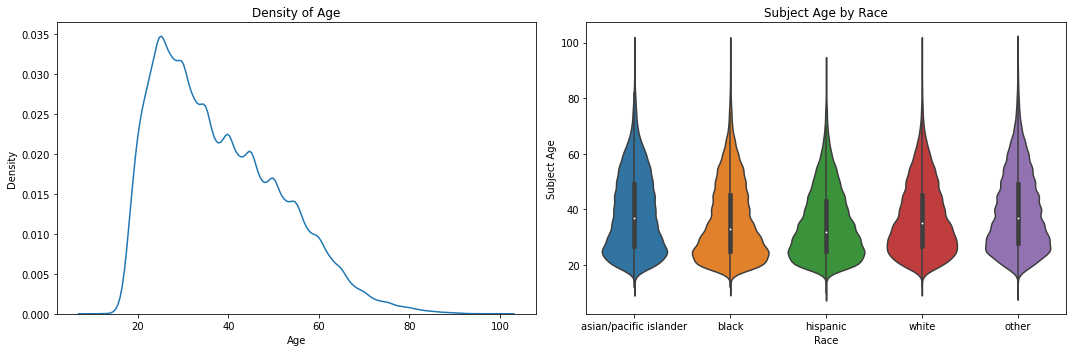

In [194]:
plt.figure(tight_layout=True, figsize=(15, 5))
plt.subplot(1,2,1)
sns.kdeplot(df['subject_age'])
plt.title('Density of Age')
plt.xlabel('Age')
plt.subplot(1,2,2)
sns.violinplot(data=df, x="subject_race", y="subject_age").set_xticklabels(tick)
plt.title('Subject Age by Race')
plt.ylabel('Subject Age')
plt.xlabel('Race')

Lastly, we see that our dataset has a high density of subjects ranging from 20-30 years old. 

When we use a violinplot to see age distribution by race. 



In [195]:
df.head()

,subject_age,subject_race,subject_sex,arrest_made,citation_issued,warning_issued,outcome,search_conducted,search_vehicle,reason_for_stop
355630,39.0,4,male,False,True,False,1,False,False,Mechanical or Non-Moving Violation (V.C.)
548669,25.0,4,female,False,True,False,1,False,False,Moving Violation
498704,39.0,3,male,False,True,False,1,False,False,Moving Violation
694060,25.0,1,male,False,False,True,2,False,False,Mechanical or Non-Moving Violation (V.C.)
613852,24.0,2,male,False,True,False,1,False,False,Moving Violation


#KNN Classification

Our first machine learning method we will use to predict subject_race is the KNN Classification. For this algorithm we used a random sample (5000) of our data in order for the model to run faster.  

In [196]:
def get_best(ks, acc):
    return ks[(acc.index(max(acc)))]

In [197]:
def get_train_test_accuracy(knn, X_train, X_test, y_train, y_test):
    knn.fit(X_train,y_train)
    prediction = knn.predict(X_test) 
    return accuracy_score(y_test, prediction)

In [198]:
np.random.seed(42)  

predictors = ['outcome', 'subject_age']
X = df[predictors].values
y = df['subject_race'].values

indexes = np.random.choice(y.size, size=5000)
X_mini = X[indexes]
y_mini = y[indexes]

X_train, X_test, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Getting the best K
n = 30
test_acc = []
ks = np.arange(1, n+1, 2)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='minkowski')
    acc_te = get_train_test_accuracy(knn, X_train, X_test, y_train, y_test)
    test_acc.append(acc_te)
best_k = get_best(ks, test_acc)

knn = KNeighborsClassifier(n_neighbors= best_k, algorithm='brute', metric='minkowski')
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)


Lets see how the first ten predicted values look when comapred to the actual values.  

In [199]:
print("Predictions: {}".format(y_predict[:10]))
print("Actual: {}".format(y_test[:10]))

Predictions: [4 4 4 1 4 4 4 4 1 4]
Actual: [1 1 3 4 2 1 0 4 1 0]


**Accuracy**

In [200]:
print('Accuracy: {:.2f}'.format((y_predict == y_test).mean()))

Accuracy: 0.40


**Confusion Matrix**

In [201]:
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,2,4
Actual,,,,
0,14,24,3,241
1,10,32,5,216
2,7,19,5,154
3,8,10,4,141
4,30,20,11,546


Text(33.0, 0.5, 'actual')

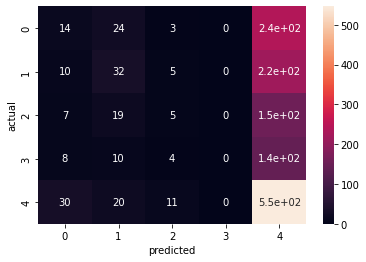

In [202]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")

**Learning Curve**

The learning curve for our KNN classification shows that as the training size increases, the differnce between the test score and training score becomes smaller. Our plot also tells us that our . 

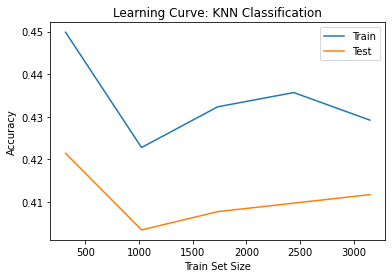

In [203]:
train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores, label='Test')
plt.title('Learning Curve: KNN Classification')
plt.xlabel('Train Set Size')
plt.ylabel('Accuracy')
plt.legend()

**Forward Selection**

Our accuracy score is less that 50%. Lets see if adding more features improves our accuracy score. Again we will be using a random sample size of 5,000. We will also convert all the categorical values to numerical ones. 

In [204]:
all_num = df = pd.get_dummies(df, drop_first = True)
all_features = list(all_num.columns)
all_features.remove('subject_race')
np.random.seed(42)  

X = all_num[all_features].values
y = all_num['subject_race'].values

indexes = np.random.choice(y.size, size=5000)
X_mini = X[indexes]
y_mini = y[indexes]

X_train, X_test, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors= best_k, algorithm='brute', metric='minkowski')
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

In [205]:
remaining = list(range(X_train.shape[1]))
selected = []
n = 10
while len(selected) < n:
    accuracy = 1e7
    for i in remaining:
        scores = cross_val_score(KNeighborsClassifier(n_neighbors= best_k, algorithm='brute', metric='minkowski'), X_train[:, selected+[i]], y_train, scoring='accuracy', cv=10)
        if scores.mean() < accuracy:
          accuracy = (predictions == y_test).mean() 
          i_min = i
    remaining.remove(i_min)
    selected.append(i_min)
    print('num features: {}; accuracy: {:.2f}'.format(len(selected), accuracy))

num features: 1; accuracy: 0.40
num features: 2; accuracy: 0.40
num features: 3; accuracy: 0.40
num features: 4; accuracy: 0.40
num features: 5; accuracy: 0.40
num features: 6; accuracy: 0.40
num features: 7; accuracy: 0.40
num features: 8; accuracy: 0.40
num features: 9; accuracy: 0.40
num features: 10; accuracy: 0.40


By seeing 10 features being added, we see no improvement in our accuracy since it remained the same. As a result, we will keep the two predictors (outcome, subject_age). 

#Non-Linear SVC Classification

**Accuracy**

In [206]:
np.random.seed(42)  

predictors = ['outcome', 'subject_age']
X = df[predictors].values
y = df['subject_race'].values

indexes = np.random.choice(y.size, size=5000)
X_mini = X[indexes]
y_mini = y[indexes]

X_train, X_test, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='scale'))
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict)))

Accuracy: 0.41


**Cofusion Matrix**

In [207]:
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'])

Predicted,1,4
Actual,,
0,10,272
1,25,238
2,13,172
3,3,160
4,12,595


Text(33.0, 0.5, 'actual')

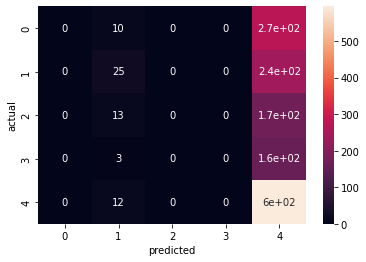

In [208]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")

**Learning Curve**

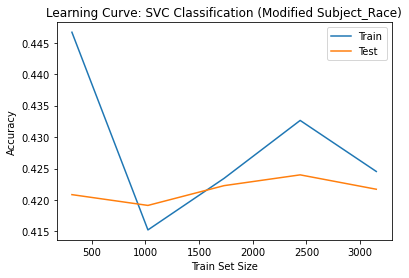

In [209]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores, label='Test')
plt.title('Learning Curve: SVC Classification (Modified Subject_Race)')
plt.xlabel('Train Set Size')
plt.ylabel('Accuracy')
plt.legend()

#Decision Tree Classification

Now we will us the Decision Tree Classification model to see how it performance and accuracy score. 

In [210]:
predictors = ['outcome', 'subject_age']
X = df[predictors].values
y = df['subject_race'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

clf = DecisionTreeClassifier(max_depth = 5, random_state=0, min_samples_split=5, min_samples_leaf=5)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

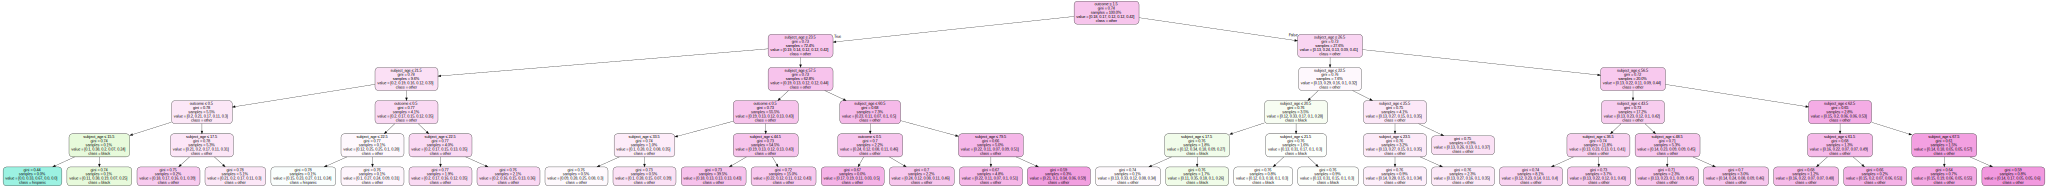

In [211]:
target_names = ['asian/pacific islander', 'black','hispanic', 'white', 'other']
n = export_graphviz(clf,precision=2, feature_names=predictors, proportion=True, class_names=target_names, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(n)
graph

**Accuracy**

In [212]:
print('Accuracy: {:.2f}'.format((y_predict == y_test).mean()))

Accuracy: 0.42


**Confusion Matrix**

In [213]:
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'])

Predicted,1,2,4
Actual,,,
0,613,4,21121
1,1492,18,19338
2,815,6,14656
3,385,6,13902
4,1247,19,50833


Text(33.0, 0.5, 'actual')

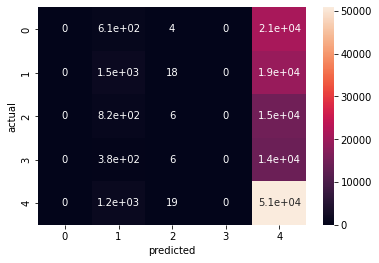

In [214]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")

**Learning Curve**

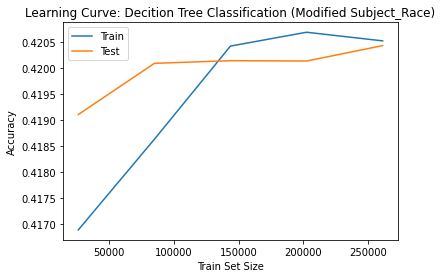

In [215]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores, label='Test')
plt.title('Learning Curve: Decition Tree Classification (Modified Subject_Race)')
plt.xlabel('Train Set Size')
plt.ylabel('Accuracy')
plt.legend()

By using the Decision Tree Classification model we see that our accuracy improve by +0.02 when compared to the KNN Classification model. 

Overall our three models had a accuracy percentage that was < 50% we saw that adding more features to our model was neither and advantage or disadvantage. Although we saw a slight increase in accuracy with using a Decision Tree & SVC model vs KNN, it mostly predicted two subject races (Other and Black). 

It may be the case that most of the data on this dataset contains more reports of Black subjects than others. 

We will repeat the same models but now we will determine if there is a differnce in accuracy when we predict if the subject's race is Black or Other. Other will be a combination of races in the dataset that are not Black. 

In [216]:
other_df = df
other_df.subject_race = other_df.subject_race.replace({2:0, 3:0, 4:0})

#KNN Classification

We will do another KNN Classification to predict if the subject_race is Black or Other. We will see how tuning the target variable effects the accuracy score. Again, we will be using a smaller random sample from our data, 5000.

**Accuracy**

In [217]:
np.random.seed(42)  

predictors = ['outcome', 'subject_age']
X = other_df[predictors].values
y = other_df['subject_race'].values

indexes = np.random.choice(y.size, size=5000)
X_mini = X[indexes]
y_mini = y[indexes]

X_train, X_test, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Getting the best K
n = 30
test_acc = []
ks = np.arange(1, n+1, 2)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', metric='minkowski')
    acc_te = get_train_test_accuracy(knn, X_train, X_test, y_train, y_test)
    test_acc.append(acc_te)
best_k = get_best(ks, test_acc)


knn = KNeighborsClassifier(n_neighbors= best_k, algorithm='brute', metric='minkowski')
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

print('Accuracy: {:.2f}'.format((y_predict == y_test).mean()))


Accuracy: 0.82


**Confusion Matrix**

In [218]:
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'])

Predicted,0
Actual,
0,1237
1,263


Text(33.0, 0.5, 'actual')

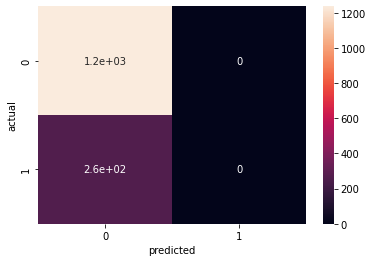

In [219]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")

**Learning Curve**

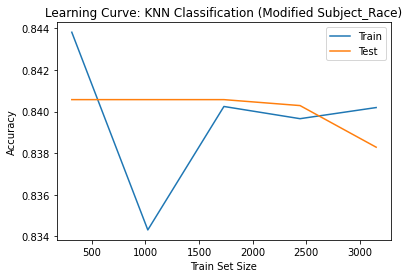

In [220]:
train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores, label='Test')
plt.title('Learning Curve: KNN Classification (Modified Subject_Race)')
plt.xlabel('Train Set Size')
plt.ylabel('Accuracy')
plt.legend()

#Non-Linear SVC Classification

Next we will see how the SVC model performs with our target variable. We will also use a random sample of 5000 for this model. 

**Accuracy**

In [221]:
np.random.seed(42)  

predictors = ['outcome', 'subject_age']
X = other_df[predictors].values
y = other_df['subject_race'].values

indexes = np.random.choice(y.size, size=5000)
X_mini = X[indexes]
y_mini = y[indexes]

X_train, X_test, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='scale'))
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict)))

Accuracy: 0.82


**Confusion Matrix**

In [222]:
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'])

Predicted,0
Actual,
0,1237
1,263


Text(33.0, 0.5, 'actual')

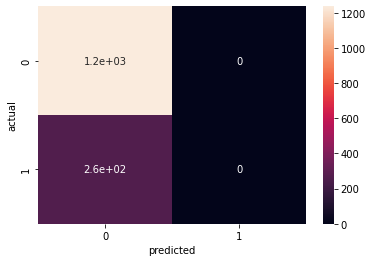

In [223]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")

**Learning Curve**

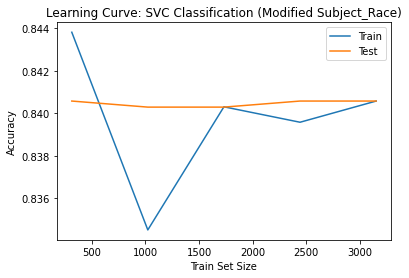

In [224]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores, label='Test')
plt.title('Learning Curve: SVC Classification (Modified Subject_Race)')
plt.xlabel('Train Set Size')
plt.ylabel('Accuracy')
plt.legend()

#Decision Tree Classification

Now we will perform the Decision Tree model using the whole sample data size. 

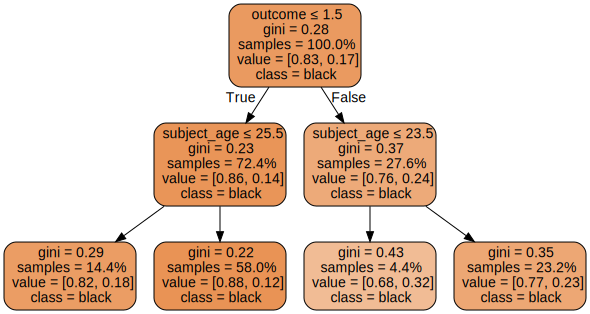

In [225]:
predictors = ['outcome', 'subject_age']
X = other_df[predictors].values
y = other_df['subject_race'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

clf = DecisionTreeClassifier(max_depth = 2, random_state=0, min_samples_split=5, min_samples_leaf=5)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

target_names = ['black','other']
n = export_graphviz(clf,precision=2, feature_names=predictors, proportion=True, class_names=target_names, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(n)
graph

**Accuracy**

In [226]:
print('Accuracy: {:.2f}'.format((y_predict == y_test).mean()))


Accuracy: 0.83


**Confusion Matrix**

In [227]:
pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'])

Predicted,0
Actual,
0,103607
1,20848


Text(33.0, 0.5, 'actual')

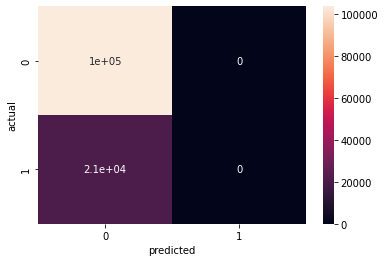

In [228]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")

**Learning Curve**

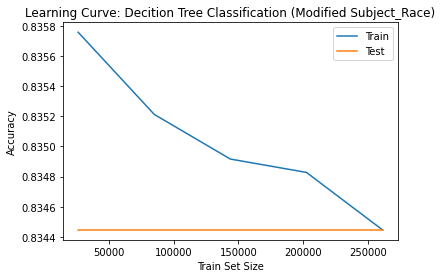

In [229]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores, label='Test')
plt.title('Learning Curve: Decition Tree Classification (Modified Subject_Race)')
plt.xlabel('Train Set Size')
plt.ylabel('Accuracy')
plt.legend()

#Conclusion

For this model we used three different models: KNN, Decision Tree, and SVC. In the first three observations we used all races in the dataset ('asian/pacific islander', 'black','hispanic', 'white', 'other'). We noticed a low accuracy score for these observations. There was a slight improvement in accuracy score when we used the Decision Tree and SVC models but overall scores remained below 50%. 

When we noticed that subject_race distribution was skewed we wanted to see how the models would predict if the subject was Black or Other. To do this we combined all the other races that were not Black and performed the same three models. Our accuracy scores improved from tuning our data. We obtained scores higher than 50%